**Chapter 15 – Processing Sequences Using RNNs and CNNs**

In [1]:
import tensorflow as tf
import keras

Define the default font sizes to make the figures prettier:

In [2]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

# Basic RNNs

We use data from Chicago's Transit Authority, to predict the number of passengers that will ride on bus and rail the next day. It originally comes from Chicago's Transit Authority, and was downloaded from the [Chicago's Data Portal](https://homl.info/ridership).

In [3]:
keras.utils.get_file(
    "ridership.tgz",
    "https://github.com/ageron/data/raw/main/ridership.tgz",
    cache_dir=".",
    extract=True
)

108512/108512 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


'./datasets/ridership_extracted'

In [5]:
import pandas as pd
from pathlib import Path

path = Path("datasets/ridership_extracted/ridership/CTA_-_Ridership_-_Daily_Boarding_Totals.csv")
df = pd.read_csv(path, parse_dates=["service_date"])
df.columns = ["date", "day_type", "bus", "rail", "total"]  # shorter names
df = df.sort_values("date").set_index("date")
df = df.drop("total", axis=1)  # no need for total, it's just bus + rail
df = df.drop_duplicates()  # remove duplicated months (2011-10 and 2014-07)

In [6]:
df.head(15)

,day_type,bus,rail
date,,,
2001-01-01,U,297192,126455
2001-01-02,W,780827,501952
2001-01-03,W,824923,536432
2001-01-04,W,870021,550011
2001-01-05,W,890426,557917
2001-01-06,A,577401,255356
2001-01-07,U,375831,169825
2001-01-08,W,985221,590706
2001-01-09,W,978377,599905


In [7]:
df['day_type'].unique()
# W -> Weekday
# A -> Saturday
# U -> Sundays + holidays

array(['U', 'W', 'A'], dtype=object)

Let's look at the first few months of 2019 (note that Pandas treats the range boundaries as inclusive):

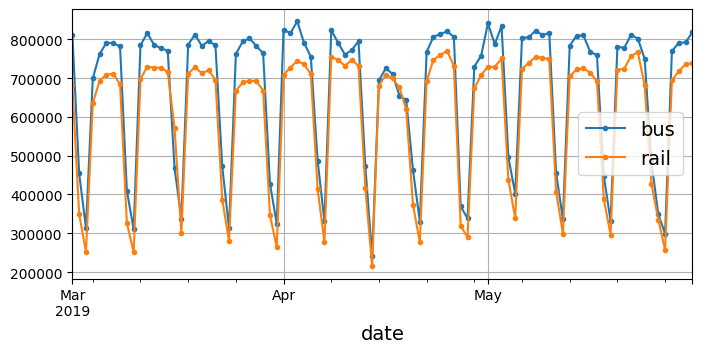

In [8]:
import matplotlib.pyplot as plt

df["2019-03":"2019-05"].plot(grid=True, marker=".", figsize=(8, 3.5))
plt.show()

## Time Series Data

- **Time series** data contains data with values at different time steps.
  - Usually, the time steps are equally spaced.
- A **univariate** time series contains a single value at each time step.
- A **multivariate** time series contains several values at each time step.
  - The ridership data is multivariate.
  
## Time Series Forecasting

- Predicting future values of a time series is called **time series forecasting** and is the most typical task when dealing with time series.
- The ridership data shows a weekly **seasonality**.
  - A **naive forecast** can just copy the value from the previous week to make the forecast.

## Visualizing the Naive Forecast

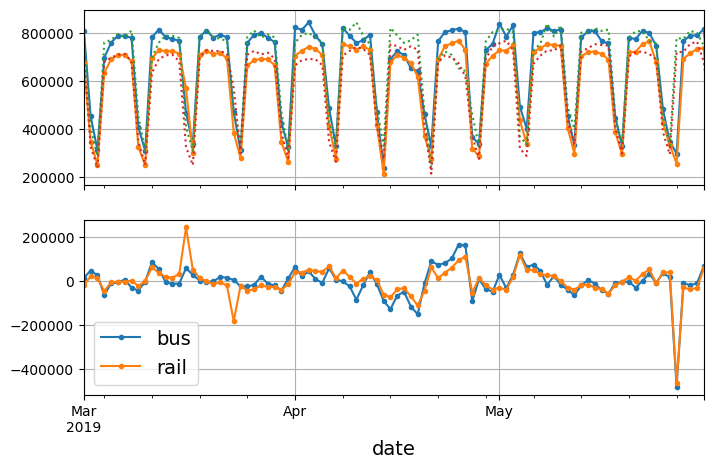

In [9]:
# .diff(7) gives the change over 7 rows — for example, a week-over-week difference if your data is daily.
diff_7 = df[["bus", "rail"]].diff(7)["2019-03":"2019-05"]

fig, axs = plt.subplots(2, 1, sharex=True, figsize=(8, 5))
df.plot(ax=axs[0], legend=False, marker=".")  # original time series
df.shift(7).plot(ax=axs[0], grid=True, legend=False, linestyle=":")  # lagged
diff_7.plot(ax=axs[1], grid=True, marker=".")  # 7-day difference time series
axs[0].set_ylim([170_000, 900_000])  # extra code – beautifies the plot
plt.show()

## Error Measures for Naive Forecast

- The **mean absolute error** (MAE) is the average absolute difference between the forecasts and the targets.
  - It's hard to tell whether this is good or bad.
- The **mean absolute percentage error** (MAPE) is the average absolute difference between the forecasts and the targets, divided by the absolute value of the targets, expressed as a percentage.
  - This is easier to interpret.

In [10]:
diff_7.abs().mean()

bus     43915.608696
rail    42143.271739
dtype: float64

In [11]:
targets = df[["bus", "rail"]]["2019-03":"2019-05"]
(diff_7 / targets).abs().mean()

bus     0.082938
rail    0.089948
dtype: float64

## Error Measures for Naive Forecast

- Note how the MAE for "bus" (43915) is higher than the MAE for "rail" (42143).
- This MAE means that we are off by about 43915 passengers on average for "bus".
- The MAPE for "bus" is approximately 8.3%, which means that we are off by about 8.3% on average for "bus", while we are off by about 9.0% on average for "rail".
  - The MAPE thus shows that the naive forecast is better for "bus" than for "rail" (even though the MAE suggests otherwise).

## 15.3.1 The ARMA Model Family

## ARMA Model Family

- ARMA stands for **autoregressive moving average**.
- An ARMA model predicts the future values as
  - an autoregressive linear combination of the $p$ previous values
  - and a linear combination of the past $q$ forecast errors.

We don't go into the details of ARMA models, but they are a popular model family for time series forecasting.


## 15.3.2 Preparing the Data for Machine Learning Models

## Goal of the Forecasting Model

- We try to build a model to predict tomorrow's ridership, based on the ridership of the previous $56$ days.
- The inputs to the model will be sequences each containing $56$ values for the time steps $t-55$ up to $t$.
- For each input sequence, the output will be a single value, the predicted ridership at time step $t+1$.

## Training Data

- The training data will be every 56-day window from the past, and the target for each window is the value immediately after the window.
- Keras has a utility function to help us: `keras.utils.timeseries_dataset_from_array`.
  - It takes a time series as input and produces a `tf.data.Dataset` object (see Chapter 13).
  - The `Dataset` will contain windows of the desired length, and the targets for each window.

## `timeseries_dataset_from_array`

In [12]:
import tensorflow as tf

my_series = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
my_dataset = keras.utils.timeseries_dataset_from_array(
    my_series,
    targets=my_series[3:],  # the targets are 3 steps into the future
    sequence_length=3,
    batch_size=2
)
list(my_dataset)

2025-11-13 10:14:07.820834: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4
2025-11-13 10:14:07.820886: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-11-13 10:14:07.820905: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-11-13 10:14:07.820947: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-11-13 10:14:07.820964: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2025-11-13 10:14:07.951552: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


[(<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
  array([[0, 1, 2],
         [1, 2, 3]], dtype=int32)>,
  <tf.Tensor: shape=(2,), dtype=int32, numpy=array([3, 4], dtype=int32)>),
 (<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
  array([[2, 3, 4],
         [3, 4, 5]], dtype=int32)>,
  <tf.Tensor: shape=(2,), dtype=int32, numpy=array([5, 6], dtype=int32)>),
 (<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
  array([[4, 5, 6],
         [5, 6, 7]], dtype=int32)>,
  <tf.Tensor: shape=(2,), dtype=int32, numpy=array([7, 8], dtype=int32)>),
 (<tf.Tensor: shape=(1, 3), dtype=int32, numpy=array([[6, 7, 8]], dtype=int32)>,
  <tf.Tensor: shape=(1,), dtype=int32, numpy=array([9], dtype=int32)>)]

## Explanation

- `[0,1,2,3,4,5,6,7,8,9]` contains the following windows of length 3 and their targets:
  - `[0,1,2]` with target `3`
  - `[1,2,3]` with target `4`
  - `[2,3,4]` with target `5`
  - `[3,4,5]` with target `6`
  - `[4,5,6]` with target `7`
  - `[5,6,7]` with target `8`
  - `[6,7,8]` with target `9`       
- The number of windows is not a multiple of the batch size, so the last batch is smaller.

## The `window` Method of `Dataset`

- We can achieve the same with the `window` method of `Dataset`.
  - This method is more complex, but it is more flexible.
- `window` returns a dataset of window datasets (much like a list of lists).

## The `window` Method: Example

In [20]:
for window_dataset in tf.data.Dataset.range(10).window(4, shift=1):
    for element in window_dataset:
        print(f"{element}", end=" ")
    print()

0 1 2 3 
1 2 3 4 
2 3 4 5 
3 4 5 6 
4 5 6 7 
5 6 7 8 
6 7 8 9 
7 8 9 
8 9 
9 


2025-11-13 10:20:18.892576: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-11-13 10:20:18.894992: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-11-13 10:20:18.896865: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-11-13 10:20:18.898676: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-11-13 10:20:18.900124: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-11-13 10:20:18.901211: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-11-13 10:20:18.902334: W tensorflow/core/framework/local_rendezvous.cc:404] L

- Use `drop_remainder=True` to drop the windows that are too short.

## The `flat_map` Method

- The `flat_map` method can be used to flatten a dataset of datasets.
- `flat_map` takes a function as argument that allows to transform each dataset before flattening.

## The `flat_map` Method: Example

**Apply a sliding window**  
`dataset = dataset.window(4, shift=1, drop_remainder=True)`
* This creates windows (sub-datasets) of size 4, sliding by 1 each time.
    * size=4 → each window contains 4 elements
    * shift=1 → move the window by 1 element for the next one
    * drop_remainder=True → ignore incomplete windows at the end

So now the dataset is conceptually like this:  
Window 1: [0, 1, 2, 3]  
Window 2: [1, 2, 3, 4]  
Window 3: [2, 3, 4, 5]  
Window 4: [3, 4, 5, 6]  
Window 5: [4, 5, 6, 7]  
Window 6: [5, 6, 7, 8]  
Window 7: [6, 7, 8, 9]  
At this point, each element of dataset is itself a Dataset object (a 'window dataset'), not a tensor yet.

**Flatten and batch each window**  
`dataset = dataset.flat_map(lambda window_dataset: window_dataset.batch(4))`

* `window_dataset.batch(4)` turns each small window-dataset into a Tensor of shape (4,).
* `flat_map` merges (flattens) all those tensors back into a single dataset stream.

So now `dataset` yields actual tensors:

tf.Tensor([0, 1, 2, 3], shape=(4,), dtype=int64)  
tf.Tensor([1, 2, 3, 4], shape=(4,), dtype=int64)  
tf.Tensor([2, 3, 4, 5], shape=(4,), dtype=int64)  
tf.Tensor([3, 4, 5, 6], shape=(4,), dtype=int64)  
tf.Tensor([4, 5, 6, 7], shape=(4,), dtype=int64)  
tf.Tensor([5, 6, 7, 8], shape=(4,), dtype=int64)  
tf.Tensor([6, 7, 8, 9], shape=(4,), dtype=int64)  

In [14]:
dataset = tf.data.Dataset.range(10).window(4, shift=1, drop_remainder=True)
#! drop_remaider=True verwijderd rijen niet gelijk aan 4 elementen
dataset = dataset.flat_map(lambda window_dataset: window_dataset.batch(4))
for window_tensor in dataset:
    print(f"{window_tensor}")

[0 1 2 3]
[1 2 3 4]
[2 3 4 5]
[3 4 5 6]
[4 5 6 7]
[5 6 7 8]
[6 7 8 9]


2025-11-13 10:17:22.022526: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


## Creating a Small Helper Function

- Create a helper function to create a windowed dataset:

In [15]:
def to_windows(dataset, length):
    dataset = dataset.window(length, shift=1, drop_remainder=True)
    return dataset.flat_map(lambda window_ds: window_ds.batch(length))

## Add the Targets

- Call `map` to create tuples with windows and targets:

In [16]:
dataset = to_windows(tf.data.Dataset.range(10), 4)
list(dataset.batch(2))

2025-11-13 10:17:44.447611: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


[<tf.Tensor: shape=(2, 4), dtype=int64, numpy=
 array([[0, 1, 2, 3],
        [1, 2, 3, 4]])>,
 <tf.Tensor: shape=(2, 4), dtype=int64, numpy=
 array([[2, 3, 4, 5],
        [3, 4, 5, 6]])>,
 <tf.Tensor: shape=(2, 4), dtype=int64, numpy=
 array([[4, 5, 6, 7],
        [5, 6, 7, 8]])>,
 <tf.Tensor: shape=(1, 4), dtype=int64, numpy=array([[6, 7, 8, 9]])>]

In [17]:
dataset = dataset.map(lambda window: (window[:-1], window[-1]))
list(dataset.batch(2))

2025-11-13 10:17:56.612531: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


[(<tf.Tensor: shape=(2, 3), dtype=int64, numpy=
  array([[0, 1, 2],
         [1, 2, 3]])>,
  <tf.Tensor: shape=(2,), dtype=int64, numpy=array([3, 4])>),
 (<tf.Tensor: shape=(2, 3), dtype=int64, numpy=
  array([[2, 3, 4],
         [3, 4, 5]])>,
  <tf.Tensor: shape=(2,), dtype=int64, numpy=array([5, 6])>),
 (<tf.Tensor: shape=(2, 3), dtype=int64, numpy=
  array([[4, 5, 6],
         [5, 6, 7]])>,
  <tf.Tensor: shape=(2,), dtype=int64, numpy=array([7, 8])>),
 (<tf.Tensor: shape=(1, 3), dtype=int64, numpy=array([[6, 7, 8]])>,
  <tf.Tensor: shape=(1,), dtype=int64, numpy=array([9])>)]

## Creating Train/Val/Test Sets

In [18]:
rail_train = df["rail"]["2016-01":"2018-12"] / 1e6
rail_valid = df["rail"]["2019-01":"2019-05"] / 1e6
rail_test = df["rail"]["2019-06":] / 1e6

- Note how we scale the values down by a factor of one million.
  - The values will be close to the $[0,1]$ range, which is good for neural networks.

## Note on Validation and Test Sets

> When dealing with time series, it is generally a good idea to split across time, rather than randomly.

## Creating the `Dataset`s for Training

In [22]:
seq_length = 56
train_ds = keras.utils.timeseries_dataset_from_array(
    rail_train.to_numpy(),
    targets=rail_train[seq_length:],
    sequence_length=seq_length,
    batch_size=32,
    shuffle=True,
    seed=42
)
valid_ds = keras.utils.timeseries_dataset_from_array(
    rail_valid.to_numpy(),
    targets=rail_valid[seq_length:],
    sequence_length=seq_length,
    batch_size=32
)
list(train_ds.take(1))

2025-11-13 10:31:42.360369: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


[(<tf.Tensor: shape=(32, 56), dtype=float64, numpy=
  array([[0.369396, 0.290753, 0.726945, ..., 0.71368 , 0.720369, 0.70129 ],
         [0.842885, 0.891357, 1.146516, ..., 0.131542, 0.292312, 0.490822],
         [0.723488, 0.748753, 0.754918, ..., 0.718317, 0.445798, 0.396317],
         ...,
         [0.460385, 0.357897, 0.748976, ..., 0.742502, 0.775495, 0.804635],
         [0.327173, 0.739174, 0.781301, ..., 0.821158, 0.815629, 0.416588],
         [0.402811, 0.816014, 0.826518, ..., 0.80725 , 0.721083, 0.474411]])>,
  <tf.Tensor: shape=(32,), dtype=float64, numpy=
  array([0.449322, 0.537443, 0.744165, 0.668762, 0.71522 , 0.797545,
         0.751342, 0.320982, 0.813161, 0.332004, 0.689577, 0.690845,
         0.742215, 0.743427, 0.741459, 0.285153, 0.755604, 0.81009 ,
         0.73144 , 0.660176, 0.336441, 0.736966, 0.786422, 0.799529,
         0.692183, 0.832417, 0.292995, 0.329445, 0.65065 , 0.528345,
         0.334275, 0.338339])>)]

The data is now ready and we can train any regression model.


## 15.3.3 Forecasting Using a Linear Model

## Using a Linear Model

We train a linear model with the Huber loss.

In [23]:
model = keras.Sequential([
    keras.layers.Input(shape=[seq_length]),
    keras.layers.Dense(1)
])
# Compile and train
early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_mae", patience=50, restore_best_weights=True)
opt = keras.optimizers.SGD(learning_rate=0.02, momentum=0.9)
model.compile(loss=keras.losses.Huber(), optimizer=opt, metrics=["mae"])
history = model.fit(train_ds, validation_data=valid_ds, epochs=500, callbacks=[early_stopping_cb])

Epoch 1/500


2025-11-13 10:49:15.219533: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0332 - mae: 0.1923 - val_loss: 0.0118 - val_mae: 0.1279
Epoch 2/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0100 - mae: 0.1069 - val_loss: 0.0072 - val_mae: 0.0950
Epoch 3/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0080 - mae: 0.0945 - val_loss: 0.0063 - val_mae: 0.0886
Epoch 4/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0075 - mae: 0.0893 - val_loss: 0.0058 - val_mae: 0.0854
Epoch 5/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0069 - mae: 0.0850 - val_loss: 0.0055 - val_mae: 0.0811
Epoch 6/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0070 - mae: 0.0883 - val_loss: 0.0057 - val_mae: 0.0824
Epoch 7/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0065 - mae: 0.0810 - val_loss: 0.0072 - val_mae: 0.0964
Epoch 8/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0070 - mae: 0.0877 - val_loss: 0.0048 - val_mae: 0.0738
Epoch 9/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0059 - mae: 0.

In [24]:
# extra code – evaluates the model
valid_loss, valid_mae = model.evaluate(valid_ds)
valid_mae * 1e6

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0023 - mae: 0.0374


37428.16299200058

## 15.3.4 Forecasting Using a Simple RNN

## Using a Simple RNN

- The linear model is better than naive forecasting, but it is worse than the SARIMA model (which we didn't cover in the slides).
  - The SARIMA model is a variant of the ARMA model family, with seasonality and differencing.
- The most basic RNN contains a single recurrent layer with a single neuron.

## Input to a Recurrent Layer

- Recurrent layers expect inputs of shape `[batch_size, time_steps, dimensionality]`.
  - For univariate time series, the dimensionality is 1.
- The `shape` of `keras.layers.Input` never includes the batch size.
- Since recurrent layers can accept sequences of arbitrary length, the second dimension is `None`: ```shape=[None, 1]```.
  - Note: the datasets actually contain data of shape `[batch_size, time_steps]`, but Keras adds the missing dimension automatically.

## Working of Recurrent Layer

- For this model $h_\text{(init)} = 0$ and this is passed to the single recurrent neuron along with the first input $x_{(0)}$.
- The neuron computes a weighted sum of these values, adds a bias term and applies the activation function.
- The result is the first output $\hat y_{(0)}$, which also equals the new state $h_{(0)}$.
- The new state $h_{(0)}$ is passed to the neuron along with the next input $x_{(1)}$ and the process repeats for all steps.
- The last value is $\hat y_{(55)}$, because there are 56 time steps.

## `return_sequences` and default activation

> By default, recurrent layers in Keras only return the final output vector. To make them return one output per time step, you must set `return_sequences=True`.

> The default activation function for recurrent layer is the hyperbolic tangent (`tanh`).

In [25]:
model = keras.Sequential([
    # Note: shape on the input layer!
    # Also note: default activation is tanh
    keras.layers.Input(shape=[None, 1]),
    keras.layers.SimpleRNN(1)
])

In [26]:
# extra code – defines a utility function we'll reuse several times

def fit_and_evaluate(model, train_set, valid_set, learning_rate, epochs=500):
    early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_mae", patience=50, restore_best_weights=True)
    opt = keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
    model.compile(loss=keras.losses.Huber(), optimizer=opt, metrics=["mae"])
    history = model.fit(train_set, validation_data=valid_set, epochs=epochs,callbacks=[early_stopping_cb])
    valid_loss, valid_mae = model.evaluate(valid_set)
    return valid_mae * 1e6

In [27]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 1)              │             3 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3 (12.00 B)

 Trainable params: 3 (12.00 B)

 Non-trainable params: 0 (0.00 B)

In [28]:
fit_and_evaluate(model, train_ds, valid_ds, learning_rate=0.02)

Epoch 1/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 23s 677ms/step - loss: 0.4377 - mae: 0.7856 - val_loss: 0.0204 - val_mae: 0.1203
Epoch 2/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 21s 639ms/step - loss: 0.0544 - mae: 0.2745 - val_loss: 0.0663 - val_mae: 0.3195
Epoch 3/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 21s 638ms/step - loss: 0.0449 - mae: 0.2376 - val_loss: 0.0275 - val_mae: 0.1562
Epoch 4/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 22s 660ms/step - loss: 0.0182 - mae: 0.1560 - val_loss: 0.0157 - val_mae: 0.1474
Epoch 5/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 22s 676ms/step - loss: 0.0161 - mae: 0.1601 - val_loss: 0.0158 - val_mae: 0.1369
Epoch 6/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 23s 698ms/step - loss: 0.0158 - mae: 0.1541 - val_loss: 0.0154 - val_mae: 0.1379
Epoch 7/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 24s 717ms/step - loss: 0.0155 - mae: 0.1565 - val_loss: 0.0152 - val_mae: 0.1358
Epoch 8/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 23s 688ms/step - loss: 0.0152 - mae: 0.1521 - val_loss: 0.0148 - val_mae: 0.1378
Epoch 9/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 2

102804.72785234451

## Results of the Simple RNN

- The result of the simple RNN is extremely poor: MAE is more than 100000!
- There are two reasons for this:
  - A single recurrent neuron can only use the current input and the output value from the previous time step. It has very limited short-term memory. Moreover, this model only has 3 parameters: one weight for the input, one weight for the output of the previous time step, and one bias term. (The linear model had 57 parameters.)
  - The default activation function is `tanh` which outputs values between -1 and 1. The targets, however, contain values from 0 to around 1.4 .


## Fixing Both Problems

- We can fix both problems by
  - Using a recurrent layer containing 32 neurons.
  - Adding a dense layer on top of it with a single neuron and no activation function.
- The recurrent layer will be able to carry much more information from one time step to the next, and the dense layer will project the final output from 32 dimensions down to 1, without any constraints on the value range.

In [29]:
univar_model = keras.Sequential([
    keras.layers.Input(shape=[None, 1]),
    keras.layers.SimpleRNN(32),
    keras.layers.Dense(1)  # no activation function by default
])

In [30]:
# extra code – compiles, fits, and evaluates the model, like earlier
fit_and_evaluate(univar_model, train_ds, valid_ds, learning_rate=0.05)

Epoch 1/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step - loss: 0.0205 - mae: 0.1548 - val_loss: 0.0056 - val_mae: 0.0848
Epoch 2/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step - loss: 0.0059 - mae: 0.0796 - val_loss: 0.0029 - val_mae: 0.0559
Epoch 3/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step - loss: 0.0047 - mae: 0.0696 - val_loss: 0.0056 - val_mae: 0.0846
Epoch 4/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step - loss: 0.0052 - mae: 0.0755 - val_loss: 0.0045 - val_mae: 0.0737
Epoch 5/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 47s 1s/step - loss: 0.0043 - mae: 0.0651 - val_loss: 0.0025 - val_mae: 0.0492
Epoch 6/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - loss: 0.0044 - mae: 0.0683 - val_loss: 0.0026 - val_mae: 0.0498
Epoch 7/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - loss: 0.0043 - mae: 0.0656 - val_loss: 0.0036 - val_mae: 0.0627
Epoch 8/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 47s 1s/step - loss: 0.0047 - mae: 0.0688 - val_loss: 0.0044 - val_mae: 0.0714
Epoch 9/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step - loss: 0.004

28249.112889170647

This model can reach a validation MAE of 27703. This is the best model we've trained so far.

## Inspecting the Model (Extra)

- The model summary tells us that the model has 1121 parameters:

In [31]:
univar_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_1 (SimpleRNN)        │ (None, 32)             │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,244 (8.77 KB)

 Trainable params: 1,121 (4.38 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,123 (4.39 KB)

## Inspecting the Model (Extra)

- The input sequence to the recurrent layer is univariate, and the output has 32 neurons, thus
  - $\mathbf{W_X} \in \mathbb{R}^{1 \times 32}$ and $\mathbf{W_Y} \in \mathbb{R}^{32 \times 32}$.
  - The bias has 32 neurons.
  - Thus: $32 + 32 \times 32 + 32 = 1088$ parameters.
- The dense layer takes as input a vector of length 32 and projects it down to a single dimension. Thus, it has 32 weights and one bias, for a total of 33 parameters.

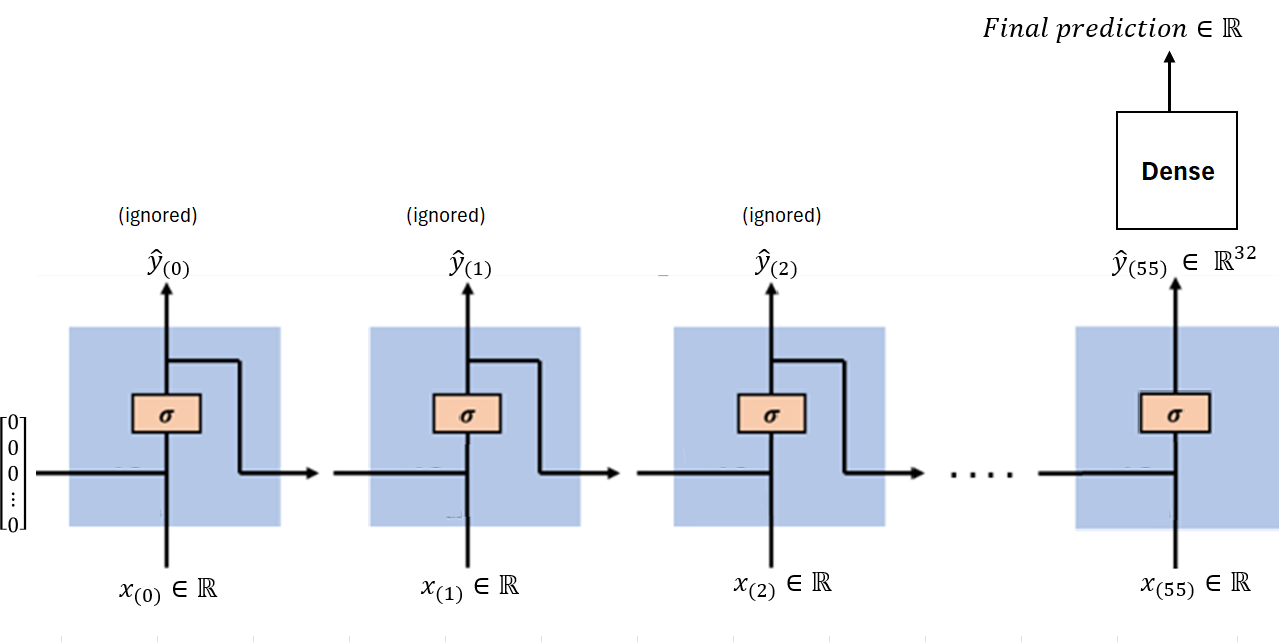

## Remark

- We've only normalized the time series by dividing by 1 million.
- We didn't remove trend nor seasonality.
- We can probably get even better performance by removing trend and seasonality, e.g. by using differencing.

## 15.3.5 Forecasting Using a Deep RNN

## Using a Deep RNN

- In a **deep RNN** multiple recurrent layers are stacked on top of each other.
- This is easy in Keras, just add more recurrent layers to the model.
  - Do not forget to use `return_sequences=True` for all recurrent layers (except the last one).

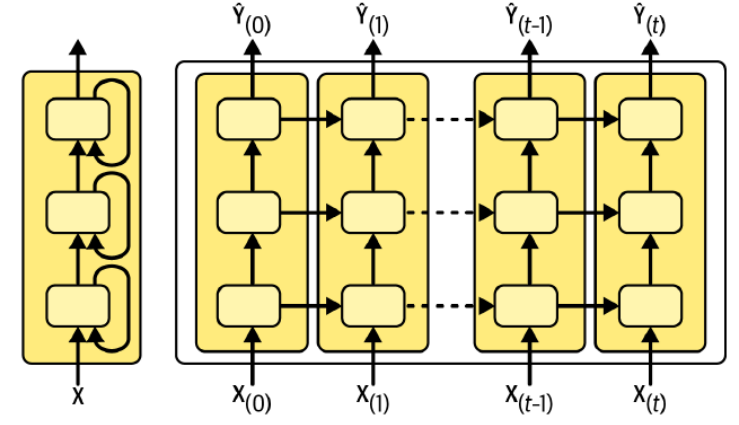

- In the following code, we stacked three recurrent layers.
  - The first two are sequence-to-sequence layers, so they return sequences.
  - The last one is a sequence-to-vector layer, so it returns a single vector.
- Again, we add a `Dense` layer on top of the recurrent layers to project the outputs down to a single value.

In [32]:
deep_model = keras.Sequential([
    keras.layers.Input(shape=[None, 1]),
    keras.layers.SimpleRNN(32, return_sequences=True),
    keras.layers.SimpleRNN(32, return_sequences=True),
    keras.layers.SimpleRNN(32),
    keras.layers.Dense(1)
])

\begin{aligned}
\text{Layer 1 (RNN)} &: 32(1 + 32 + 1) = 1088 \\
\text{Layer 2 (RNN)} &: 32(32 + 32 + 1) = 2080 \\
\text{Layer 3 (RNN)} &: 32(32 + 32 + 1) = 2080 \\
\text{Dense} &: 32 \times 1 + 1 = 33 \\
\hline
\text{Total} &: 1088 + 2080 + 2080 + 33 = 5281
\end{aligned}

In [ ]:
# extra code – compiles, fits, and evaluates the model, like earlier
fit_and_evaluate(deep_model, train_ds, valid_ds, learning_rate=0.01)

Epoch 1/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 213s 6s/step - loss: 0.0516 - mae: 0.2414 - val_loss: 0.0208 - val_mae: 0.1352
Epoch 2/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 207s 6s/step - loss: 0.0114 - mae: 0.1210 - val_loss: 0.0051 - val_mae: 0.0803
Epoch 3/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 392s 12s/step - loss: 0.0073 - mae: 0.0906 - val_loss: 0.0055 - val_mae: 0.0870
Epoch 4/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 765s 24s/step - loss: 0.0054 - mae: 0.0753 - val_loss: 0.0026 - val_mae: 0.0513
Epoch 5/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 180s 5s/step - loss: 0.0055 - mae: 0.0742 - val_loss: 0.0027 - val_mae: 0.0531
Epoch 6/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 179s 5s/step - loss: 0.0044 - mae: 0.0615 - val_loss: 0.0029 - val_mae: 0.0539
Epoch 7/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 120s 4s/step - loss: 0.0043 - mae: 0.0608 - val_loss: 0.0024 - val_mae: 0.0452
Epoch 8/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 126s 4s/step - loss: 0.0045 - mae: 0.0635 - val_loss: 0.0028 - val_mae: 0.0529
Epoch 9/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 122s 4s/step - 

In [ ]:
deep_model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_2 (SimpleRNN)        │ (None, None, 32)       │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_3 (SimpleRNN)        │ (None, None, 32)       │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_4 (SimpleRNN)        │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,281 (20.63 KB)

 Trainable params: 5,281 (20.63 KB)

 Non-trainable params: 0 (0.00 B)

## Results

- This RNN performs worse than the previous one: validation MAE is about 31211.
- It is probably too large for the task at hand.
  - First recurrent layer has: $32 + 32 \times 32 + 32 = 1088$ parameters (as before)
  - The second and third recurrent layer each have: $32\times 32 (\mathbf{W_X}) + 32 \times 32 (\mathbf{W_Y}) + 32 (\mathbf{b}) = 2080$ parameters.
  - The final dense layer still has 33 parameters:
  - Total number of parameters: $1088 + 2080 + 2080 + 33 = 5281$.

## 15.3.6 Forecasting Multivariate Time Series

## Forecasting Multivariate Time Series

- We can forecast multivariate time series with almost no change to the network architecture.
- Example: forecast the rail ridership using
  - the bus and rail data as input
  - and the day type as well. (This is OK, since we know in advance whether tomorrow is going to be a weekday, weekend or holiday.) We shift the day type series one day so that the model gets tomorrow's day type as input.
  - The day type will be one-hot encoded.

## Preprocessing using Pandas

In [ ]:
# use both bus & rail series as input
df_mulvar = df[["bus", "rail"]] / 1e6
# we know tomorrow's type
df_mulvar["next_day_type"] = df["day_type"].shift(-1)
# one-hot encode the day type
df_mulvar = pd.get_dummies(df_mulvar)

In [ ]:
mulvar_train = df_mulvar["2016-01":"2018-12"]
mulvar_valid = df_mulvar["2019-01":"2019-05"]
mulvar_test = df_mulvar["2019-06":]

## Creating `tf.data.Dataset`s

In [ ]:
seq_length = 56

#! Targets zijn enkel de train (rail)
train_mulvar_ds = keras.utils.timeseries_dataset_from_array(
    mulvar_train.to_numpy().astype("float32"),  # use all 5 columns as input
    targets=mulvar_train["rail"][seq_length:],  # forecast only the rail series
    sequence_length=seq_length,
    batch_size=32,
    shuffle=True,
    seed=42
)
valid_mulvar_ds = keras.utils.timeseries_dataset_from_array(
    mulvar_valid.to_numpy().astype("float32"),
    targets=mulvar_valid["rail"][seq_length:],
    sequence_length=seq_length,
    batch_size=32
)

## Creating the RNN

- The input shape is now `[None, 5]` because at each time step the model receives 5 inputs (two real values, and three binary values).
- This model reaches a validation of MAE of 22026. The best model so far!

In [ ]:
mulvar_model = keras.Sequential([
    keras.layers.Input(shape=[None, 5]),
    keras.layers.SimpleRNN(32),
    keras.layers.Dense(1)
])

In [ ]:
# extra code – compiles, fits, and evaluates the model, like earlier
fit_and_evaluate(mulvar_model, train_mulvar_ds, valid_mulvar_ds, learning_rate=0.05)

## Predicting Multiple Outputs

- You can easily adapt the RNN to forecast both the bus and rail ridership.
  - Just change the targets to `mulvar_train["bus", "rail"][seq_length:]` for training (and likewise for validation).
  - Give the `Dense` layer two neurons instead of one.
- In general, using a single model for multiple related tasks can help with performance, but in this case it doesn't.

In [ ]:
# extra code – build and train a multitask RNN that forecasts both bus and rail

seq_length = 56
train_multask_ds = keras.utils.timeseries_dataset_from_array(
    mulvar_train.to_numpy().astype("float32"),
    targets=mulvar_train[["bus", "rail"]][seq_length:],  # 2 targets per day
    sequence_length=seq_length,
    batch_size=32,
    shuffle=True,
    seed=42
)
valid_multask_ds = keras.utils.timeseries_dataset_from_array(
    mulvar_valid.to_numpy().astype("float32"),
    targets=mulvar_valid[["bus", "rail"]][seq_length:],
    sequence_length=seq_length,
    batch_size=32
)


In [ ]:
multask_model = keras.Sequential([
    keras.layers.Input(shape=[None, 5]),
    keras.layers.SimpleRNN(32),
    keras.layers.Dense(2)
])

fit_and_evaluate(multask_model, train_multask_ds, valid_multask_ds, learning_rate=0.02)

In [ ]:
# extra code – evaluates the naive forecasts for bus
bus_naive = mulvar_valid["bus"].shift(7)[seq_length:]
bus_target = mulvar_valid["bus"][seq_length:]
(bus_target - bus_naive).abs().mean() * 1e6

43441.63157894738

In [ ]:
# extra code – evaluates the multitask RNN's forecasts both bus and rail
Y_preds_valid = multask_model.predict(valid_multask_ds)
for idx, name in enumerate(["bus", "rail"]):
    mae = 1e6 * keras.metrics.mean_absolute_error(
        mulvar_valid[name][seq_length:], Y_preds_valid[:, idx])
    print(name, int(mae))

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
bus 24637
rail 24071


## Forecasting Several Steps Ahead

## Predicting Several Time Steps Ahead

- Suppose we not only want to predict tomorrow's ridership, but the next 14 days.

## Approach 1: Use Model to Predict One Day Ahead

- We can take a model like the `univar_model` RNN that we trained and make it predict the next value.
- This value is then added to the input sequence (acting as if the predicted value actually occurred) and the model is used to predict the next value.
- We can repeat this process for the desired number of time steps.


In [ ]:
import numpy as np

# X.shape = (1,56,1)
X = rail_valid.to_numpy()[np.newaxis, :seq_length, np.newaxis]
for step_ahead in range(14):
    y_pred_one = univar_model.predict(X)
    X = np.concatenate([X, y_pred_one.reshape(1, 1, 1)], axis=1)
    # note: X.shape is (1,57,1), (1,58,1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


## Approach 1: Remark

> If the model makes an error at one time step, the forecasts for the following time steps are impacted as well. Errors tend to accumulate. It is best to use this technique only for a small number of time steps.

## Approach 2: Predict 14 Values at Once

- We can still use a sequence-to-vector model, but the targets will be 14 values instead of one.
- Thus, targets need to be vectors containing the next 14 values.
- We use `timeseries_dataset_from_array` but do not create targets (`targets=None`).
  - The sequences are longer: `seq_length + 14`.
  - Next, we use `map` to split each batch into inputs and targets

**split_inputs_and_targets**
- shape of `mulvar_series`: (batch_size, sequence_length, num_features)
- `mulvar_series[:, :-ahead]` → everything except the last 14 time steps.  
    Shape: (batch_size, sequence_length - ahead, num_features)
- `mulvar_series[:, -ahead: target_col]` → only the selected target feature, from the last 14 time steps.  
    Shape: (batch_size, ahead)

In [ ]:
def split_inputs_and_targets(mulvar_series, ahead=14, target_col=1):
    return mulvar_series[:, :-ahead], mulvar_series[:, -ahead:, target_col]

# mulvar_train is the multivariate training set from before

ahead_train_ds = keras.utils.timeseries_dataset_from_array(
    mulvar_train.to_numpy().astype("float32"),
    targets=None,
    #! Target is nu 14 dagen + de input data
    sequence_length=seq_length + 14,
    batch_size=32,
    shuffle=True,
    seed=42
).map(split_inputs_and_targets)

ahead_valid_ds = keras.utils.timeseries_dataset_from_array(
    mulvar_valid.to_numpy().astype("float32"),
    targets=None,
    sequence_length=seq_length + 14,
    batch_size=32
).map(split_inputs_and_targets)

list(ahead_train_ds.take(1))

Building the model is easy:

In [ ]:
ahead_model = keras.Sequential([
    keras.layers.Input(shape=[None, 5]),
    keras.layers.SimpleRNN(32),
    keras.layers.Dense(14)
])

In [ ]:
# extra code – compiles, fits, and evaluates the model, like earlier
fit_and_evaluate(ahead_model, ahead_train_ds, ahead_valid_ds,
                 learning_rate=0.02)

Predicting the next 14 values is done like this:

In [ ]:
X = mulvar_valid.to_numpy()[np.newaxis, :seq_length].astype("float32")  # shape [1, 56, 5]
Y_pred = ahead_model.predict(X)  # shape [1, 14]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


## 15.3.8 Forecasting Using a Sequence-to-Sequence Model

## Using a Seq-to-Seq Model

- Instead of predicting the next 14 values only at the last time step, we can train a model to predict the next 14 values _at each and every time step_!
  - Thus, we use a sequence-to-sequence RNN (instead of a sequence-to-vector RNN).
- Many more gradients will flow through the model, and they won't have to flow through as many time steps.
  - This will both stabilize and speed up training.

- To make this very clear:
  - At time step 0, the model will output a vector containing the forecast for time steps 1 to 14.
  - At time step 1, it will output a vector containing the forecast for time steps 2 to 15.
  - And so on.
- Thus, _the target is now a sequence_.
  - The target sequence has the same length as the input sequence.
  - At each time step, the value of the target sequence is a 14-dimensional vector.

## Preparing the Data

- Preparing the data is the hardest part.
- Remember the `to_windows` function we created earlier?

In [ ]:
def to_windows(dataset, length):
    dataset = dataset.window(length, shift=1, drop_remainder=True)
    return dataset.flat_map(lambda window_ds: window_ds.batch(length))

## Preparing the Data

- Simple use case: series `[0,1,2,3,4,5,6]`.
  - We will use use sequences of length 4.
  - At each time step, we try to predict the next two values.
- Thus, for `[0,1,2,3]` the target should be `[[1,2],[2,3],[3,4],[4,5]]`.
- for `[1,2,3,4]` the target should be `[[2,3],[3,4],[4,5],[5,6]]`.

- Calling `to_windows` twice results in the following:

In [ ]:
my_series = tf.data.Dataset.range(7)
dataset = to_windows(to_windows(my_series, 3), 4)
list(dataset)

[<tf.Tensor: shape=(4, 3), dtype=int64, numpy=
 array([[0, 1, 2],
        [1, 2, 3],
        [2, 3, 4],
        [3, 4, 5]])>,
 <tf.Tensor: shape=(4, 3), dtype=int64, numpy=
 array([[1, 2, 3],
        [2, 3, 4],
        [3, 4, 5],
        [4, 5, 6]])>]

## Preparing the Data

- Next, use `map` to split these windows of windows into inputs and targets:

In [ ]:
dataset = dataset.map(lambda S: (S[:, 0], S[:, 1:]))
list(dataset)

[(<tf.Tensor: shape=(4,), dtype=int64, numpy=array([0, 1, 2, 3])>,
  <tf.Tensor: shape=(4, 2), dtype=int64, numpy=
  array([[1, 2],
         [2, 3],
         [3, 4],
         [4, 5]])>),
 (<tf.Tensor: shape=(4,), dtype=int64, numpy=array([1, 2, 3, 4])>,
  <tf.Tensor: shape=(4, 2), dtype=int64, numpy=
  array([[2, 3],
         [3, 4],
         [4, 5],
         [5, 6]])>)]

## Note on this Data

> Even though the targets contain data also present in the input, the RNN cannot cheat. An RNN only knows about past time steps, and it cannot look into the future. It is a **causal** model.

## Utility Function

- Let's put this into a utility function (that also takes care of batching and optionally shuffling):

In [ ]:
def to_seq2seq_dataset(series, seq_length=56, ahead=14, target_col=1,
                       batch_size=32, shuffle=False, seed=None):
    ds = to_windows(tf.data.Dataset.from_tensor_slices(series), ahead + 1)
    ds = to_windows(ds, seq_length).map(lambda S: (S[:, 0], S[:, 1:, 1]))
    if shuffle:
        ds = ds.shuffle(8 * batch_size, seed=seed)
    return ds.batch(batch_size)

## Creating Train and Validation Datasets

We can now easily create the training and validation datasets:

In [ ]:
seq2seq_train = to_seq2seq_dataset(mulvar_train.astype("float32"), shuffle=True, seed=42)
seq2seq_valid = to_seq2seq_dataset(mulvar_valid.astype("float32"))

## Building the Model

Building the model is also easy:

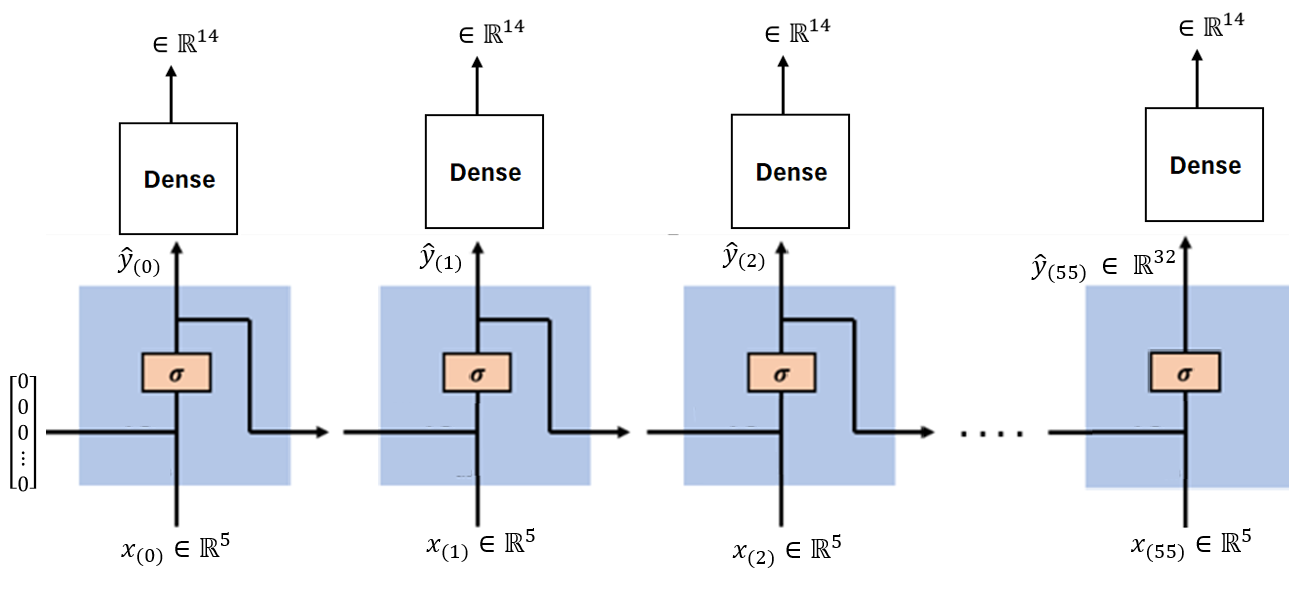

In [ ]:
seq2seq_model = keras.Sequential([
    keras.layers.Input(shape=[None, 5]),
    keras.layers.SimpleRNN(32, return_sequences=True),
    keras.layers.Dense(14)
    # equivalent: keras.layers.TimeDistributed(keras.layers.Dense(14))
    # also equivalent: keras.layers.Conv1D(14, kernel_size=1)
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
fit_and_evaluate(seq2seq_model, seq2seq_train, seq2seq_valid, learning_rate=0.1)

## Notes on the Model

- We use `return_sequences=True` because we want to predict a sequence. The output at each time step will be a vector of size 32.
- The `Dense` layer will be applied at each time step, taking the 32-dimensional vector and outputting a 14-dimensional vector.
  - An equivalent alternative is to use `Conv1D(filters=14, kernel_size=1)`. (See following slides.)

## `TimeDistributed` Layer

- The `TimeDistributed` layer lets you apply any vector-to-vector layer to every vector in the input sequence, at every time step.
  - This is done efficiently.
- For the `Dense` layer this is not needed, since it already supports sequences as inputs.
  - If the input to a `Dense` layer has shape `(batch_size, d0, d1)` then the output will have shape `(batch_size, d0, units)`, where `units` is the number of neurons in the `Dense` layer.

## `Conv1D` Layer instead of `Dense`

- The `Dense` layer has= $32\times 14 + 14$ parameters.
- A `Conv1D` layer computes a convolution over a single (time) dimension.
  - `kernel_size` is the number of time steps that the convolutional kernel will look at while considering all the channels.
  - `filters` is the number of output channels.
  - So, if we set `kernel_size` equal to 1, and `filters` equal to 14, the number of parameters will be $32 \times 14 + 14$.
  - Even more, the results will be identical as that of the `Dense` layer because each filter computes a weighted sum of the 32 inputs, and adds a bias term.

  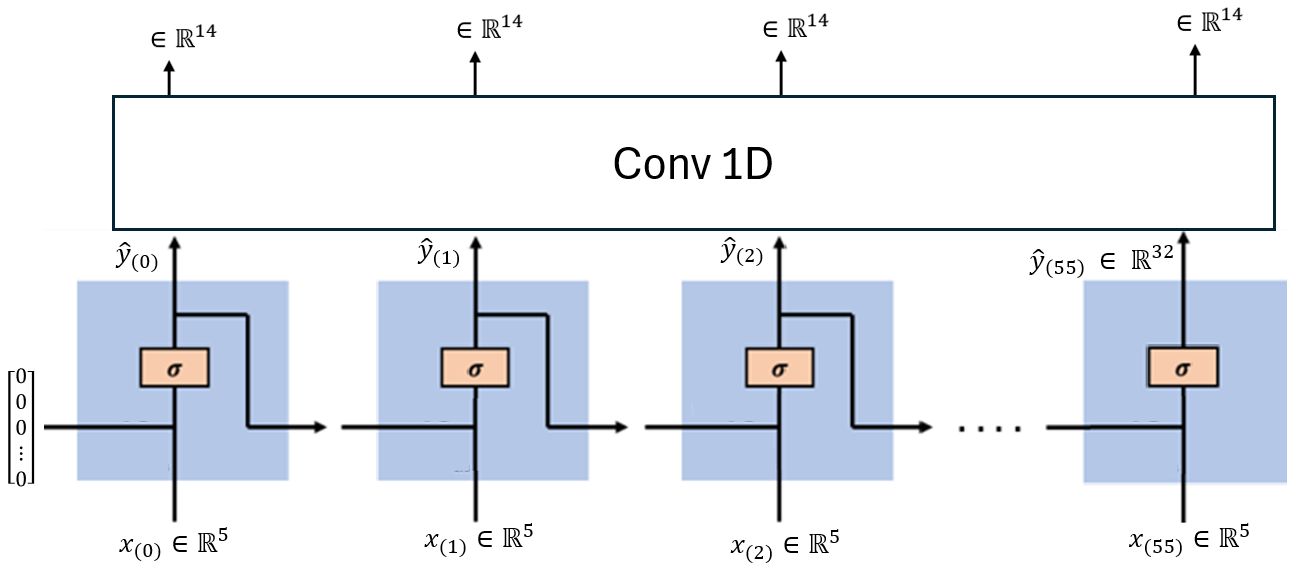

## Using the Seq-to-Seq Model

- Training the seq-to-seq model is the same as usual. During training, all the model's outputs are used.
- However, at inference time, only the very last time step matters (and the rest can be ignored).

In [ ]:
X = mulvar_valid.to_numpy()[np.newaxis, :seq_length].astype("float32")
y_pred_14 = seq2seq_model.predict(X)[0, -1]  # only the last time step's output

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


## Evaluating this Model

- For timestep $t+1$ the validation MAE for this model is 25519, for $t+2$ it is 26274 and it gradually gets worse until for $t+14$ we get a validation MAE of 34322.

In [ ]:
Y_pred_valid = seq2seq_model.predict(seq2seq_valid)
for ahead in range(14):
    preds = pd.Series(Y_pred_valid[:-1, -1, ahead],
                      index=mulvar_valid.index[56 + ahead : -14 + ahead])
    mae = (preds - mulvar_valid["rail"]).abs().mean() * 1e6
    print(f"MAE for +{ahead + 1}: {mae:,.0f}")

      1/Unknown 0s 212ms/step

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
MAE for +1: 22,242
MAE for +2: 27,117
MAE for +3: 30,122
MAE for +4: 31,985
MAE for +5: 33,041
MAE for +6: 33,558
MAE for +7: 35,231
MAE for +8: 35,040
MAE for +9: 34,688
MAE for +10: 32,936
MAE for +11: 36,477
MAE for +12: 36,923
MAE for +13: 36,409
MAE for +14: 34,706


# 15.4 Handling Long Sequences

## Long Sequences

- When you train an RNN on long sequences, the unrolled network becomes a very deep network.
  - Just, like any  deep network if may suffer from unstable gradients.
- Moreover, when an RNN processes a very long sequence, it gradually forgets the first inputs in the sequence.
  - This is called the **short-term memory problem**.

## 15.4.1 Fighting the Unstable Gradients Problem

## Techniques to Fight Unstable Gradients

- Much of the same techniques that we used to fight unstable gradients in deep networks can be used to fight unstable gradients in RNNs.
  - Good parameter initialization.
  - Faster optimizers.
  - Dropout
- Nonsaturing activation functions (like ReLU) are not helpful.
  - This is why `tanh` is the default activation function for RNNs.

## Layer Normalization

- Batch normalization doesn't help much with RNNs.
- **Layer normalization**, however, can be used with RNNs.
  - Layer normalization normalizes across the _features_ dimension (instead of the batch dimension for batch norm).
  - Layer normalization behaves the same during training and testing. No need to estimate the feature statistics across all instances in the training set like BN does.
  - Layer norm learns an offset and a scale for each input feature.
  - In an RNN layer norm is typically applied after taking the linear combination of the inputs and the hidden states (but before applying the activation function).

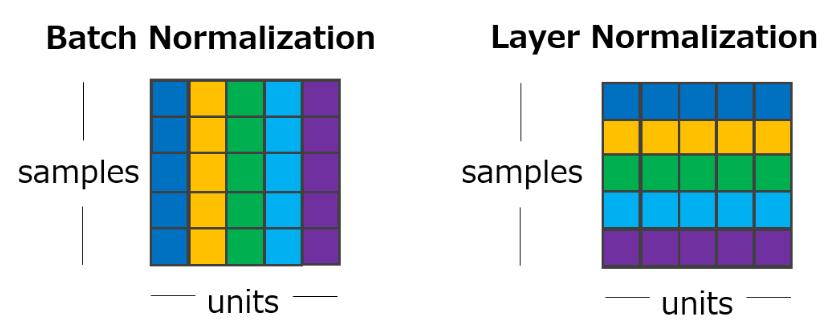

## Layer Normalization: Example (Extra)

Suppose we have a batch of 2 instances, each with 3 features:
```
[[1, 2, 3],
 [4, 5, 6]]
```
Compute the mean and standard deviation of the feature values for each instance:
```
mean = [[2], [5]], sigma = [[0.8165], [0.8165]]
```
The normalized features are:
```
[[-1.23, 0, 1.23],
 [-1.23, 0, 1.23]]
```

## Layer Normalization: Example (Extra)

Finally, the layer normalization has a learnable offset $\beta$ and scale parameter $\gamma$
for each feature. The final result is:
```
[[-1.23, 0, 1.23],
 [-1.23, 0, 1.23]]
*
[scale1, scale2, scale3]
+
[offset1, offset2, offset3]
```

## Layer Normalization: Code (Extra)

The next example (not in the book) shows how to use layer normalization in Keras:

In [ ]:
import tensorflow as tf
X = tf.constant(np.arange(1,7).reshape(2, 3), dtype=tf.float32)
norm_layer = keras.layers.LayerNormalization()
norm_layer(X)

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[-1.2238274,  0.       ,  1.2238274],
       [-1.2238274,  0.       ,  1.2238274]], dtype=float32)>

## Layer Normalization: Code (Extra)

Note that the learnable scale $\gamma$ and offset $\beta$ are initialized to all $1$ and and all $0$ respectively.

In [ ]:
norm_layer.weights

[<KerasVariable shape=(3,), dtype=float32, path=layer_normalization/gamma>,
 <KerasVariable shape=(3,), dtype=float32, path=layer_normalization/beta>]

## 15.4.2 Tackling the Short-Term Memory Problem

## New Cell Types

- In order to tackle the **short-term memory problem**, new cell types were introduced:
  - **LTSM** (Long Short-Term Memory) cell
  - **GRU** (Gated Recurrent Unit) cell
- Both these cells are more complicated than the basic RNN cell, but can be used much in the same way.
- Even though these cells are better than the basic RNN cell at remembering information, they still have trouble handling very long sequences (more than 100 time steps).

## LSTM Cell

- The *state* of an LSTM-cell is split into two vectors:
  - $\mathbf{h}_t$ can be thought of as the *short-term* state.
  - $\mathbf{c}_t$ can be thought of as the *long-term* state.
- The cell takes, as input, the input vector $\mathbf{x}_t$ and the short-term state $\mathbf{h}_{t-1}$ as well as the long-term state $\mathbf{c}_{t-1}$.
- The cell produces:
  - The output for time step $t$: $\mathbf{\hat y}_t$.
  - Both state vectors: $\mathbf{h}_t$ and $\mathbf{c}_t$.
- All three vectors $\mathbf{\hat y}_t$, $\mathbf{h}_t$ and $\mathbf{c}_t$ have the same number of components, defined when creating the LSTM cell.

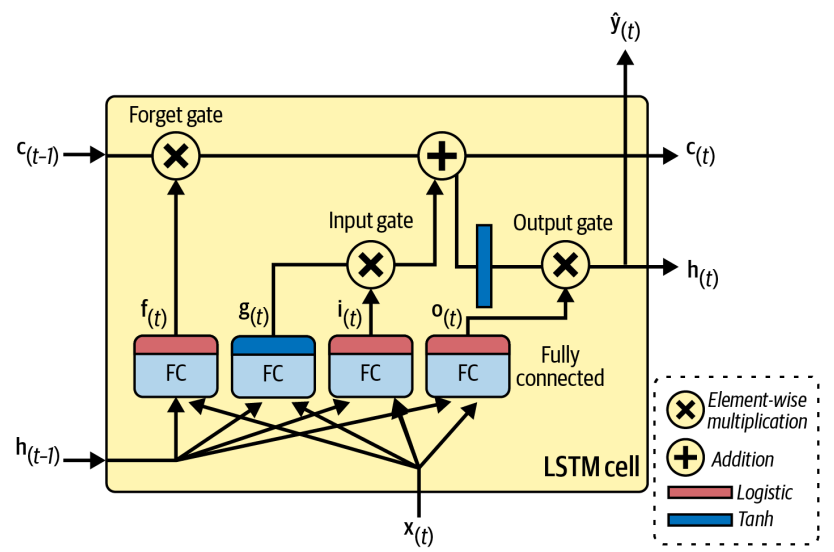


## LSTM Cell Calculations

- The LSTM cell contains 4 fully connected layers.
- Each of these takes the current (batch of)  inputs $\mathbf{X}_t$ `(batch_size, num_features)` and the (previous) short-term state $\mathbf{H}_{t-1}$ `(batch_size, units)` as inputs.
  - $\mathbf{X}_t$ and $\mathbf{H}_{t-1}$ are concatenated to yield `(batch_size, num_features + units)`
  - Each of the 4 layers has `units` neurons.
  - The $f$, $i$ and $o$ layers use `sigmoid` activation functions, while the $g$ layer uses `tanh`.

## LSTM Cell Calculations (Ctd.)

The following calculations are performed on each time step:

- $\mathbf{H}_{t-1}$ and $\mathbf{C}_{t-1}$ are extracted from the "state"
- The 4 different layers are applied to the concatenation of $\mathbf{X}_t$ and $\mathbf{H}_{t-1}$ to yield tensors $\mathbf{F}_t$, $\mathbf{I}_t$, $\mathbf{O}_t$ and $\mathbf{G}_t$ each of size `(batch_size, units)`.
- $\mathbf{C}_{t} = \mathbf{F}_t \otimes \mathbf{C}_{t-1} + \mathbf{I}_t \otimes \mathbf{G}_t$
- $\mathbf{H}_{t} = \mathbf{O}_t \otimes \tanh(\mathbf{C}_t)$
- $\mathbf{\hat Y}_t = \mathbf{H}_t$
  

In [ ]:
lstm_model = keras.models.Sequential([
    keras.layers.LSTM(32, return_sequences=True, input_shape=[None, 5]),
    keras.layers.Dense(14)
])

Just training for 5 epochs to show that it works (you can increase this if you want):

In [ ]:
fit_and_evaluate(lstm_model, seq2seq_train, seq2seq_valid,
                 learning_rate=0.1, epochs=5)

Epoch 1/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 0.1074 - mae: 0.3783 - val_loss: 0.0183 - val_mae: 0.1605
Epoch 2/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0171 - mae: 0.1609 - val_loss: 0.0172 - val_mae: 0.1437
Epoch 3/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0154 - mae: 0.1502 - val_loss: 0.0166 - val_mae: 0.1406
Epoch 4/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0147 - mae: 0.1467 - val_loss: 0.0159 - val_mae: 0.1381
Epoch 5/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0141 - mae: 0.1438 - val_loss: 0.0154 - val_mae: 0.1353
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0161 - mae: 0.1376


135253.90625

## GRU Cell

- The GRU (Gated Recurrent Unit) cell is a simplified version of the LSTM cell.
  - There is only a single state vector $\mathbf{h}_t$.
  - There are fewer "gates" inside the cell.

In [ ]:
gru_model = keras.Sequential([
    keras.layers.GRU(32, return_sequences=True, input_shape=[None, 5]),
    keras.layers.Dense(14)
])

Just training for 5 epochs to show that it works (you can increase this if you want):

In [ ]:
fit_and_evaluate(gru_model, seq2seq_train, seq2seq_valid,
                 learning_rate=0.1, epochs=5)

Epoch 1/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - loss: 0.1013 - mae: 0.3608 - val_loss: 0.0188 - val_mae: 0.1651
Epoch 2/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 0.0171 - mae: 0.1533 - val_loss: 0.0156 - val_mae: 0.1348
Epoch 3/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 0.0135 - mae: 0.1358 - val_loss: 0.0141 - val_mae: 0.1278
Epoch 4/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 0.0123 - mae: 0.1285 - val_loss: 0.0130 - val_mae: 0.1228
Epoch 5/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - loss: 0.0114 - mae: 0.1223 - val_loss: 0.0122 - val_mae: 0.1187
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0131 - mae: 0.1217


118689.66370820999

## Using 1D Convolutional Layers

- A 1D convolutional layer slides several kernels across a sequence, producing a 1D feature map per kernel.
- 1D convolutional layers can also be used to process sequences.
  - They can also be used in combination with RNNs.

```
  |-----0-----|      |-----3----|      |--... |-------52------|
         |-----1----|      |-----4----|   ... |       |-------53------|
               |-----2----|     |------5--...-51------|       |-------54------|
X:  0  1  2  3  4  5  6  7  8  9 10 11 12 ...  104 105 106 107 108 109 110 111
Y:      from 4     6     8    10    12    ...      106     108     110     112
         to 17    19    21    23    25    ...      119     121     123     125
```

## WaveNet

- **WaveNet** is an architecture to process very long sequences.
  - It is composed of a large stack of 1D convolutional layers.
  - Each convolutional layer uses a **dilation rate** (how spread apart each neuron's inputs are) that is double that of the previous layer.
    - the first convolutional layer gets a glimpse of just two time steps at a time
    - the next one sees four time steps (its receptive field is four time steps long)
    - the next one sees eight time stepd
    - and so on
  - Wavenet uses **causal padding** to ensure that the network can't look into the future. Causal padding is similar to "same" padding but all the zeroes are put on the left of the sequence.
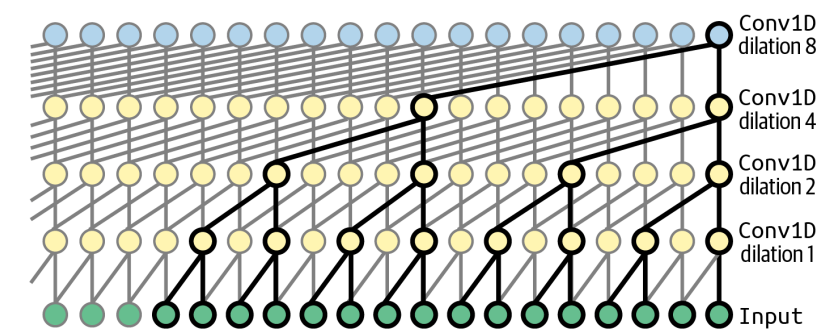  

  - We can implement two stacks of layers as shown before, and finally add a last `Conv1D` layer to produce the final predictions as follows:

```
 ⋮
C2  /\ /\ /\ /\ /\ /\ /\ /\ /\ /\ /\ /\ /\...
   \  /  \  /  \  /  \  /  \  /  \  /  \     
     /    \      /    \      /    \          
C1  /\ /\ /\ /\ /\ /\ /\ /\ /\ /\ /\  /\ /...\
X: 0  1  2  3  4  5  6  7  8  9  10 11 12 ... 111
Y: 1  2  3  4  5  6  7  8  9  10 11 12 13 ... 112
 /14 15 16 17 18 19 20 21 22  23 24 25 26 ... 125
```

In [ ]:
wavenet_model = keras.Sequential()
wavenet_model.add(keras.layers.InputLayer(input_shape=[None, 5]))
for rate in (1, 2, 4, 8) * 2:
    wavenet_model.add(keras.layers.Conv1D(
        filters=32, kernel_size=2, padding="causal", activation="relu",
        dilation_rate=rate))
wavenet_model.add(keras.layers.Conv1D(filters=14, kernel_size=1))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(
